# SEIR Model Class

In [8]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = population 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Simulated Annealing Code

C:\Users\pc-user\AppData\Local\Temp\ipykernel_16416\3446755671.py:46: RuntimeWarning: overflow encountered in scalar divide
  if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):


Best parameters: Beta=0.459, Sigma=0.043, Gamma=0.369
Best cost (MSE): 262.703


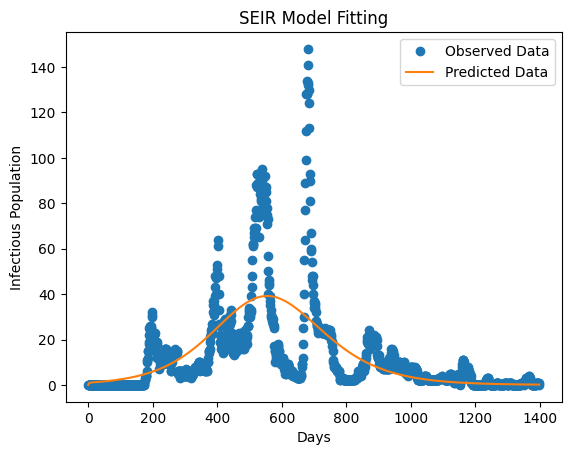

In [ ]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t):
    N = 17888
    seir_model = SEIRModel(N, beta, sigma, gamma)
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    return I  # Return only the infectious compartment for fitting


# Objective function
def objective_function(params, observed_data, initial_conditions, time_points):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    predicted_data = simulate_seir(beta, sigma, gamma, initial_conditions, time_points)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((predicted_data - observed_data)**2)
    return mse


# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter):
    # Initial parameter guesses
    current_params = [0.3, 0.1, 0.1]  # Initial guesses for beta, sigma, gamma
    current_cost = objective_function(current_params, observed_data, initial_conditions, time_points)
    best_params = current_params
    best_cost = current_cost

    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.025, 0.025) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)

        # Evaluate the new candidate solution
        new_cost = objective_function(new_params, observed_data, initial_conditions, time_points)

        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost

        # Cool down the temperature
        temp *= cooling_rate

    return best_params, best_cost


def load_observed():
  path = "nb_datasets/CITY_OF_SAN_PEDRO_processed.csv"

  df = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'])
  df_sorted = df.sort_values(by='date')
  df_sorted = df_sorted[df_sorted['barangay_Res'] == 'LANDAYAN']

  # keep relevant cols
  keep_cols = ["count_Exposed", "count_Infectious", "count_Recovered"]
  main_df = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  observed_data = main_df['count_Infectious'].to_numpy()

  total_cases = main_df['count_Infectious'].sum()
  
  return observed_data, total_cases


observed_data, total_cases = load_observed()

# Initial conditions: S, E, I, R
initial_conditions = [total_cases, 10, 0, 0]  

# Time points (days)
time_points = np.arange(len(observed_data))

# Simulated Annealing parameters
temp = 10000           # Initial temperature
cooling_rate = 0.90   # Cooling rate
max_iter = 10000       # Number of iterations

# Run the Simulated Annealing algorithm
best_params, best_cost = simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter)

# Display results
print(f"Best parameters: Beta={best_params[0]:.3f}, Sigma={best_params[1]:.3f}, Gamma={best_params[2]:.3f}")
print(f"Best cost (MSE): {best_cost:.3f}")

# Visualize the results
predicted_data = simulate_seir(*best_params, initial_conditions, time_points)

plt.plot(time_points, observed_data, 'o', label='Observed Data')
plt.plot(time_points, predicted_data, '-', label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Infectious Population')
plt.legend()
plt.title('SEIR Model Fitting')
plt.show()

## dual_annealing

Optimized parameters: beta = 0.20164500882122763, sigma = 0.3276314063919816, gamma = 0.18231211968585984


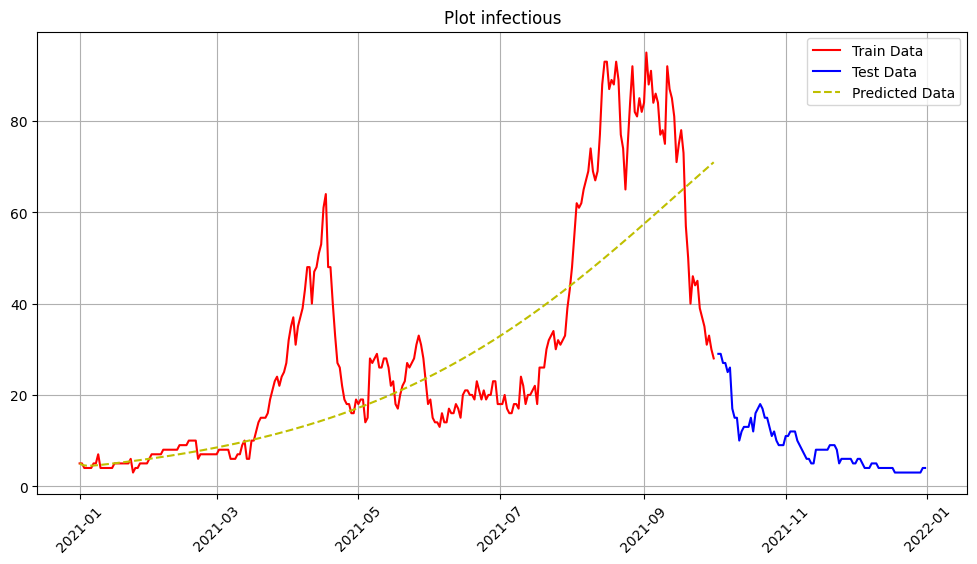

In [ ]:
from scipy.optimize import dual_annealing
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


path = "nb_datasets/CITY_OF_SAN_PEDRO_processed.csv"

df = pd.read_csv(path)

# ensure sort by date
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values(by='date')
df_sorted = df_sorted[df_sorted['barangay_Res'] == 'LANDAYAN']

# keep relevant cols
keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
main_df = df_sorted[df_sorted.columns.intersection(keep_cols)]


# Observed data (e.g., daily infections)
observed_data = main_df['count_Infectious'].to_numpy()


train_data = main_df[(main_df['date'] >= '01/01/2021') & (main_df['date'] <= '10/01/2021')]
test_data = main_df[(main_df['date'] > '10/02/2021') & (main_df['date'] <= '12/31/2021')]

i_train_data = train_data['count_Infectious'].values
i_test_data = test_data['count_Infectious'].values

time_train = np.arange(len(i_train_data))
infected_train = train_data['count_Infectious'].values

# Initial parameters
N = 30000  # Population
I0 = i_train_data[0] # Initial infected from data
E0 = I0 * 0.5  # Assume some initial exposed cases
R0 = 0  # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible


# Objective function to minimize
def objective(params):
    beta, sigma, gamma = params
    y0 = S0, E0, I0, R0
    seir_model = SEIRModel(N, beta, sigma, gamma)
    result = odeint(seir_model, y0, time_train, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    I_train_pred = I
    # Calculate the mean squared error between observed and predicted infected cases
    mse = mean_squared_error(i_train_data, I_train_pred)
    return mse


# Define bounds for parameters
bounds = [(0.1, 1.0), (1/14, 1/3), (1/14, 1/3)]  # (beta, sigma, gamma)

result = dual_annealing(objective, bounds, initial_temp = 10000, no_local_search=True, seed = 20)

optimal_params = result.x
beta_opt, sigma_opt, gamma_opt = optimal_params

print(f"Optimized parameters: beta = {beta_opt}, sigma = {sigma_opt}, gamma = {gamma_opt}")


#time_train = np.arange(len(main_df['date']))


# Initial parameters
N = 30000  # Population
I0 = i_train_data[0] # Initial infected from data
E0 = I0 * sigma_opt  # Assume some initial exposed cases
R0 = 0  # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

# Integrate the SEIR model over the training period with optimized parameters
y0 = S0, E0, I0, R0


def simulate_seir(N, beta, sigma, gamma, y0, t):
    seir_model = SEIRModel(N, beta, sigma, gamma)
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    return I  # Return only the infectious compartment 


opt_infected_result = np.array(simulate_seir(N, beta_opt, sigma_opt, gamma_opt, y0, time_train))

result_to_plot = pd.DataFrame({
    'date': train_data['date'],
    'count_Infectious': opt_infected_result
})

plt.figure(figsize=(12, 6))
plt.title('Plot infectious')
plt.plot(train_data['date'], i_train_data, 'r', label='Train Data')
plt.plot(test_data['date'], i_test_data, 'b', label='Test Data')
plt.plot(result_to_plot['date'], result_to_plot['count_Infectious'], 'y--', label='Predicted Data')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# SEIR Code

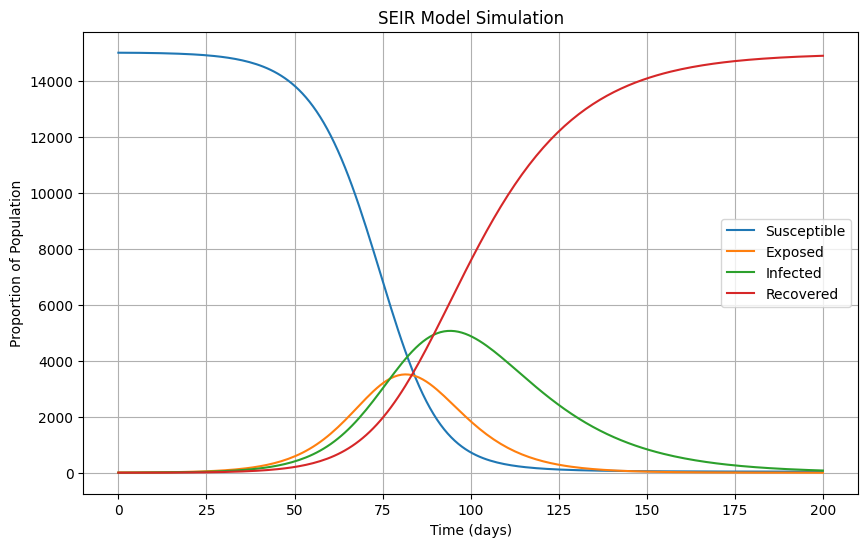

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
S0 = 0.99
E0 = 0.01
I0 = 0.00
R0 = 0.00

# Parameters
N = 15000
beta = 0.3
sigma = 0.1
gamma = 0.05

# Time vector
t = np.linspace(0, 200, 200)

# Initialize SEIR Model
seir_model = SEIRModel(N, beta, sigma, gamma)
y0 = seir_model.s, seir_model.e, seir_model.i, seir_model.r

# Solve the SEIR model equations
solution = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))

# Extract results
S, E, I, R = solution.T

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, E, label='Exposed')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

# Actual Data

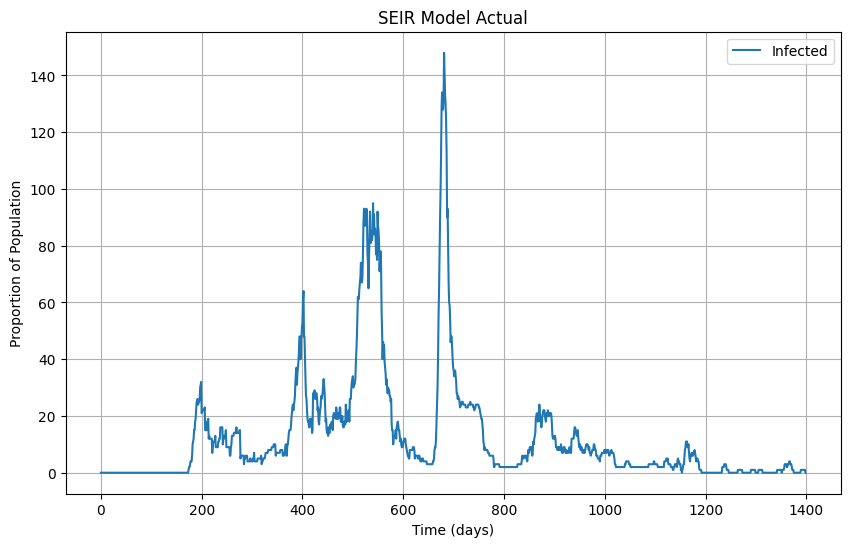

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "nb_datasets/City_OF_SAN_PEDRO_processed.csv"

df = pd.read_csv(path)

# ensure sort by date
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values(by='date')
df_sorted = df_sorted[df_sorted['barangay_Res'] == 'LANDAYAN']

# keep relevant cols
keep_cols = ["count_Exposed", "count_Infectious", "count_Recovered"]
main_df = df_sorted[df_sorted.columns.intersection(keep_cols)]

# first 100 rows(days)
#main_df = df_sorted.iloc[:100]

t = np.arange(len(main_df['count_Infectious']))
E = main_df["count_Exposed"]
I = main_df["count_Infectious"]
R = main_df["count_Recovered"]

# Plot the results
plt.figure(figsize=(10, 6))
#plt.plot(t, E, label='Exposed')
plt.plot(t, I, label='Infected')
#plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SEIR Model Actual')
plt.legend()
plt.grid(True)
plt.show()